<a href="https://colab.research.google.com/github/mohameddhameem/LLM-4-SE/blob/main/Experiment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CoDET-M4 Dataset Analysis Report
## Code Quality and Maintainability Metrics Analysis

**Dataset**: [CoDET-M4 on Hugging Face](https://huggingface.co/datasets/DaniilOr/CoDET-M4)

This analysis examines code quality metrics and characteristics from the CoDET-M4 dataset, which contains measures of code maintainability, style, and complexity across multiple code samples.

In [1]:
# Load required libraries and dataset
!pip install -q datasets

from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the CoDET-M4 dataset
dataset = load_dataset("DaniilOr/CoDET-M4")

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

dataset_without_comments.parquet:   0%|          | 0.00/458M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/500552 [00:00<?, ? examples/s]

In [2]:
# Data Preprocessing - Expand nested features and prepare for analysis
# Set SAMPLE_SIZE to None to use entire dataset, or specify a number to limit samples
SAMPLE_SIZE = None
dfs = {}

# Process each split
for split_name, split_data in dataset.items():
    # Use entire dataset if SAMPLE_SIZE is None or 0
    if SAMPLE_SIZE is None or SAMPLE_SIZE == 0:
        sample_size = len(split_data)
    else:
        sample_size = min(SAMPLE_SIZE, len(split_data))

    sample_data = split_data.select(range(sample_size))
    df = sample_data.to_pandas()

    # Expand nested 'features' column into separate columns
    if 'features' in df.columns:
        features_df = pd.json_normalize(df['features'])
        df = pd.concat([df.drop('features', axis=1), features_df], axis=1)

    # Remove large text columns not needed for analysis
    df = df.drop(columns=[col for col in ['code', 'cleaned_code'] if col in df.columns])
    dfs[split_name] = df

# Identify column types for analysis
df_train = dfs['train']
numeric_features = ['avgFunctionLength', 'avgIdentifierLength', 'avgLineLength',
                    'emptyLinesDensity', 'functionDefinitionDensity', 'maintainabilityIndex',
                    'maxDecisionTokens', 'whiteSpaceRatio']
numeric_features = [f for f in numeric_features if f in df_train.columns]
text_features = [col for col in df_train.columns if df_train[col].dtype == 'object']

## Dataset Overview & Composition

The CoDET-M4 dataset contains code quality metrics across multiple dimensions. Below is the distribution of samples in the dataset.

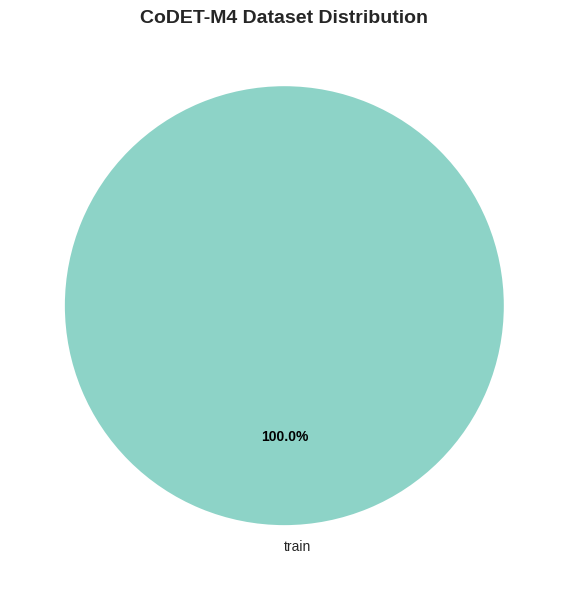

In [3]:
# Pie charts make data composition immediately intuitive - everyone gets the 'whole vs parts' concept at a glance.
# This quickly shows stakeholders whether we have balanced data or if certain splits dominate, which affects model training strategy.
split_sizes = {split: len(data) for split, data in dfs.items()}
fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.Set3(np.linspace(0, 1, len(split_sizes)))
wedges, texts, autotexts = ax.pie(split_sizes.values(), labels=split_sizes.keys(), autopct='%1.1f%%',
                                    colors=colors, startangle=90)
ax.set_title('CoDET-M4 Dataset Distribution', fontsize=14, fontweight='bold')
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontweight('bold')
plt.tight_layout()
plt.show()

## Code Quality Metrics Analysis

This section examines the distribution of key code quality metrics across the dataset. Each metric represents a different dimension of code quality and maintainability.

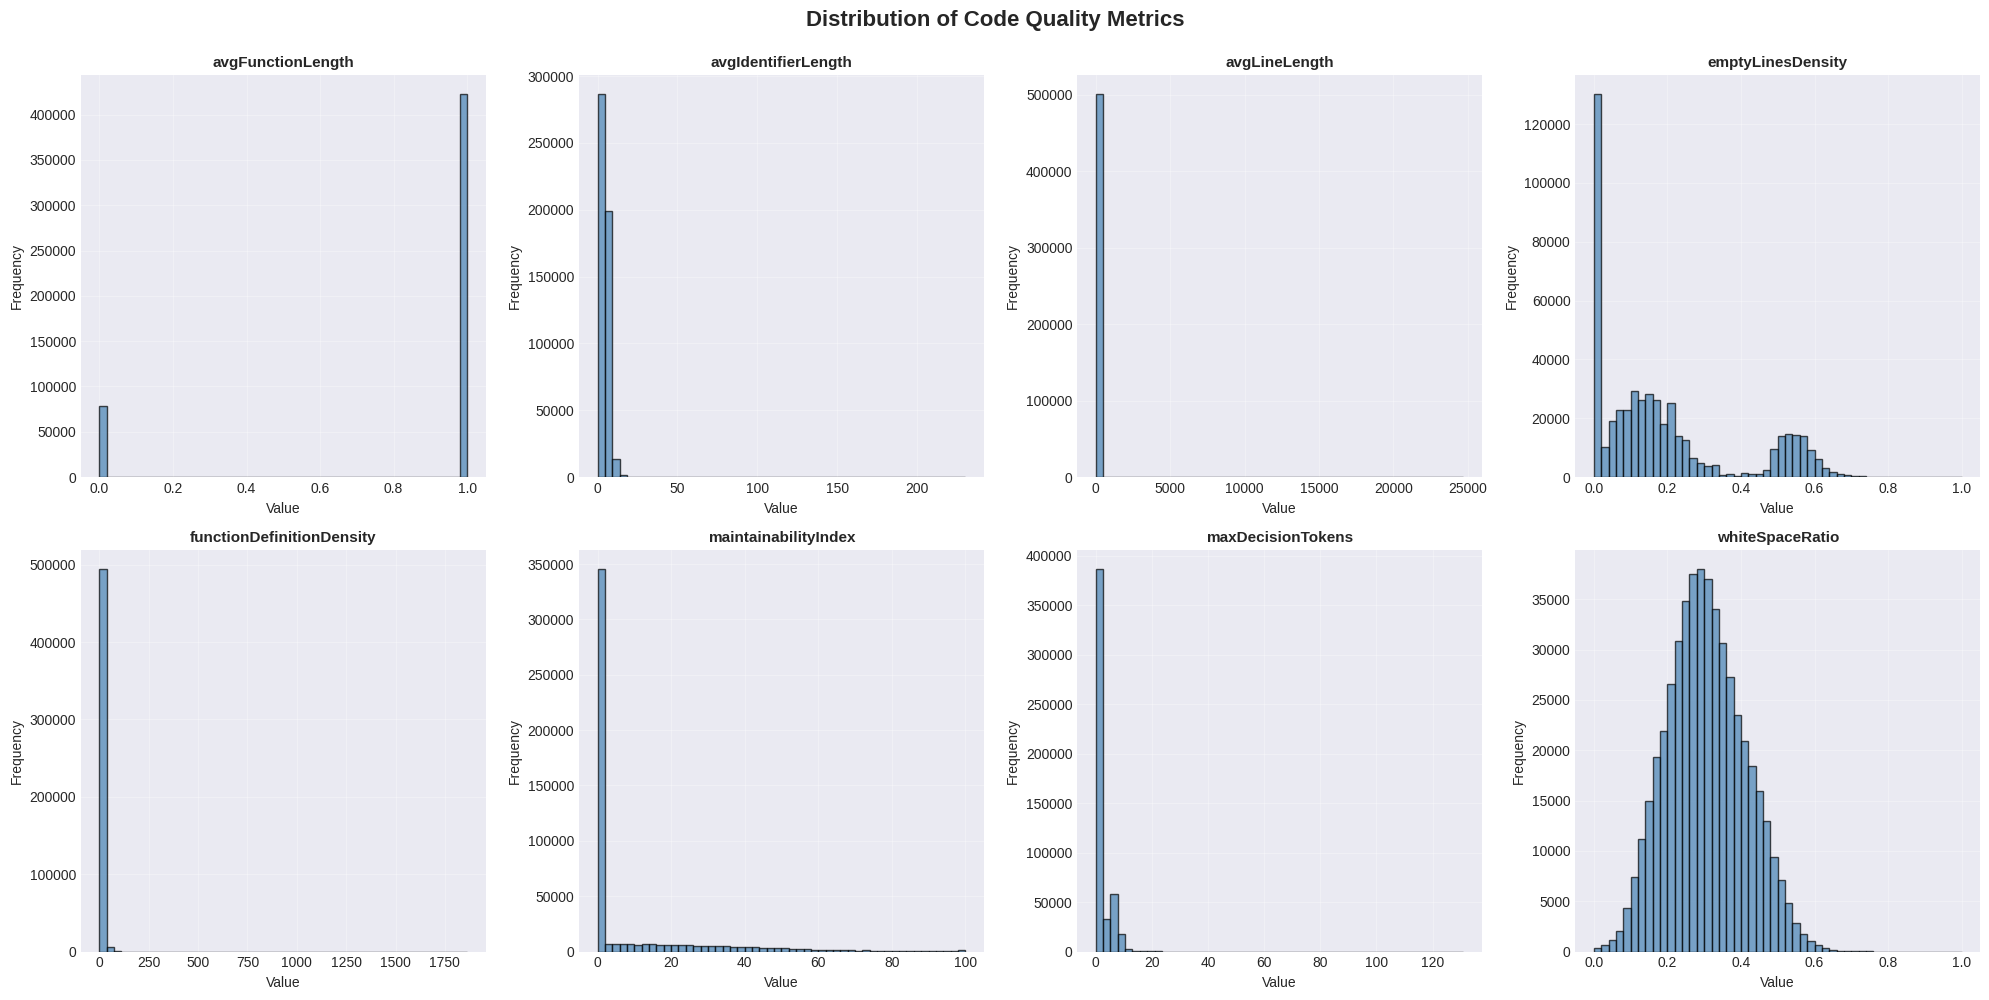

In [4]:
# Histograms reveal data skewness and outliers better than any table - you immediately see if a metric is normally distributed or heavily skewed.
# This helps us spot data quality issues early and decide on preprocessing strategies (log transforms, outlier handling) before modeling.
if numeric_features:
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()

    for idx, feature in enumerate(numeric_features):
        axes[idx].hist(df_train[feature].dropna(), bins=50, color='steelblue', edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'{feature}', fontweight='bold', fontsize=11)
        axes[idx].set_xlabel('Value')
        axes[idx].set_ylabel('Frequency')
        axes[idx].grid(True, alpha=0.3)

    for idx in range(len(numeric_features), len(axes)):
        axes[idx].set_visible(False)

    fig.suptitle('Distribution of Code Quality Metrics', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

## Feature Correlations

Understanding relationships between code quality metrics helps identify which metrics move together and reinforce each other.

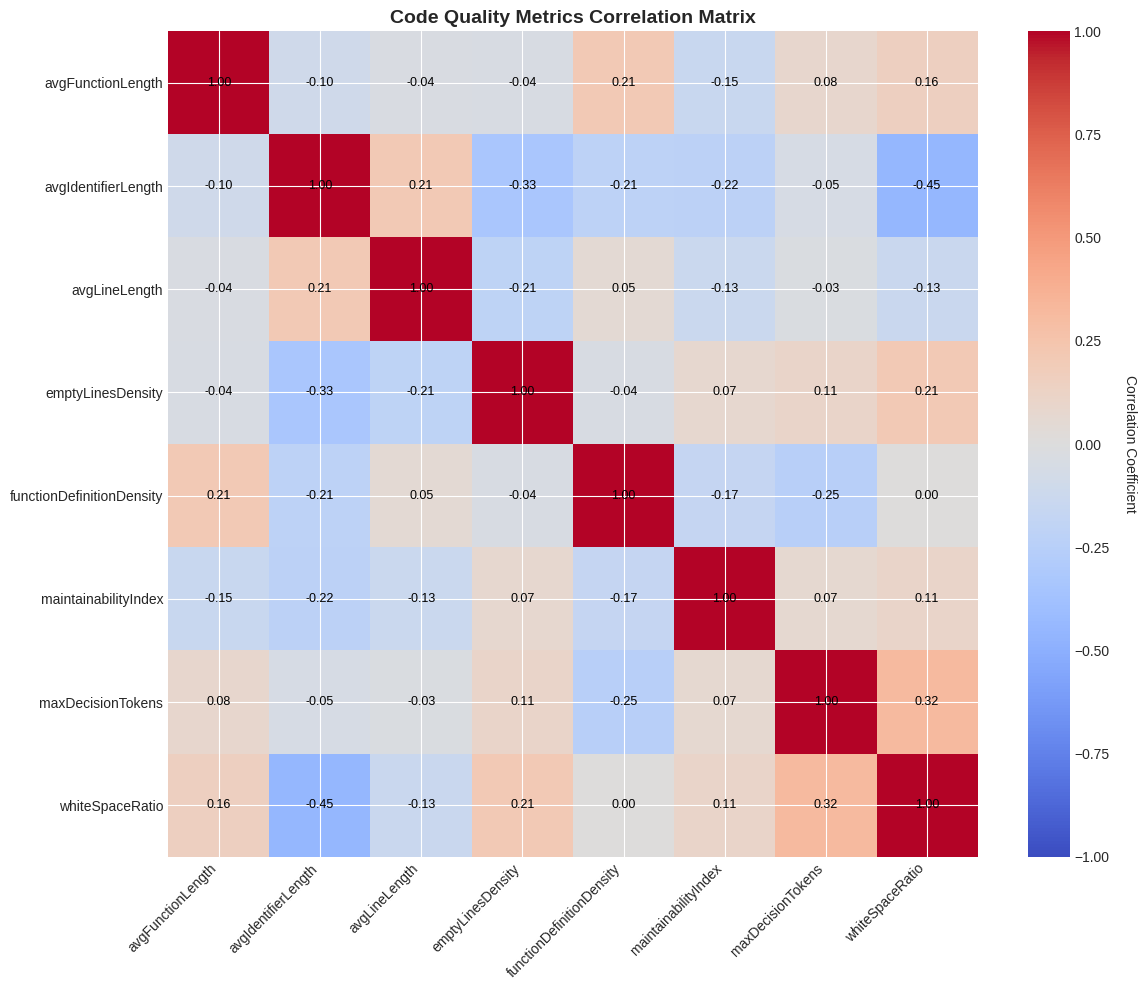

In [5]:
# Heatmaps let us spot correlated features instantly - those strong reds or blues jump out, but wall of numbers would be missed.
# Identifying redundant metrics saves us from feature engineering waste and helps explain model behaviors to the business.
if numeric_features:
    correlation_matrix = df_train[numeric_features].corr()

    fig, ax = plt.subplots(figsize=(12, 10))
    im = ax.imshow(correlation_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)

    ax.set_xticks(np.arange(len(numeric_features)))
    ax.set_yticks(np.arange(len(numeric_features)))
    ax.set_xticklabels(numeric_features, rotation=45, ha='right', fontsize=10)
    ax.set_yticklabels(numeric_features, fontsize=10)

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Correlation Coefficient', rotation=270, labelpad=20)

    for i in range(len(numeric_features)):
        for j in range(len(numeric_features)):
            ax.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                   ha="center", va="center", color="black", fontsize=9)

    ax.set_title('Code Quality Metrics Correlation Matrix', fontweight='bold', fontsize=14)
    plt.tight_layout()
    plt.show()

## Code Content Analysis

Analysis of the text content characteristics - code and implementation details in the dataset.

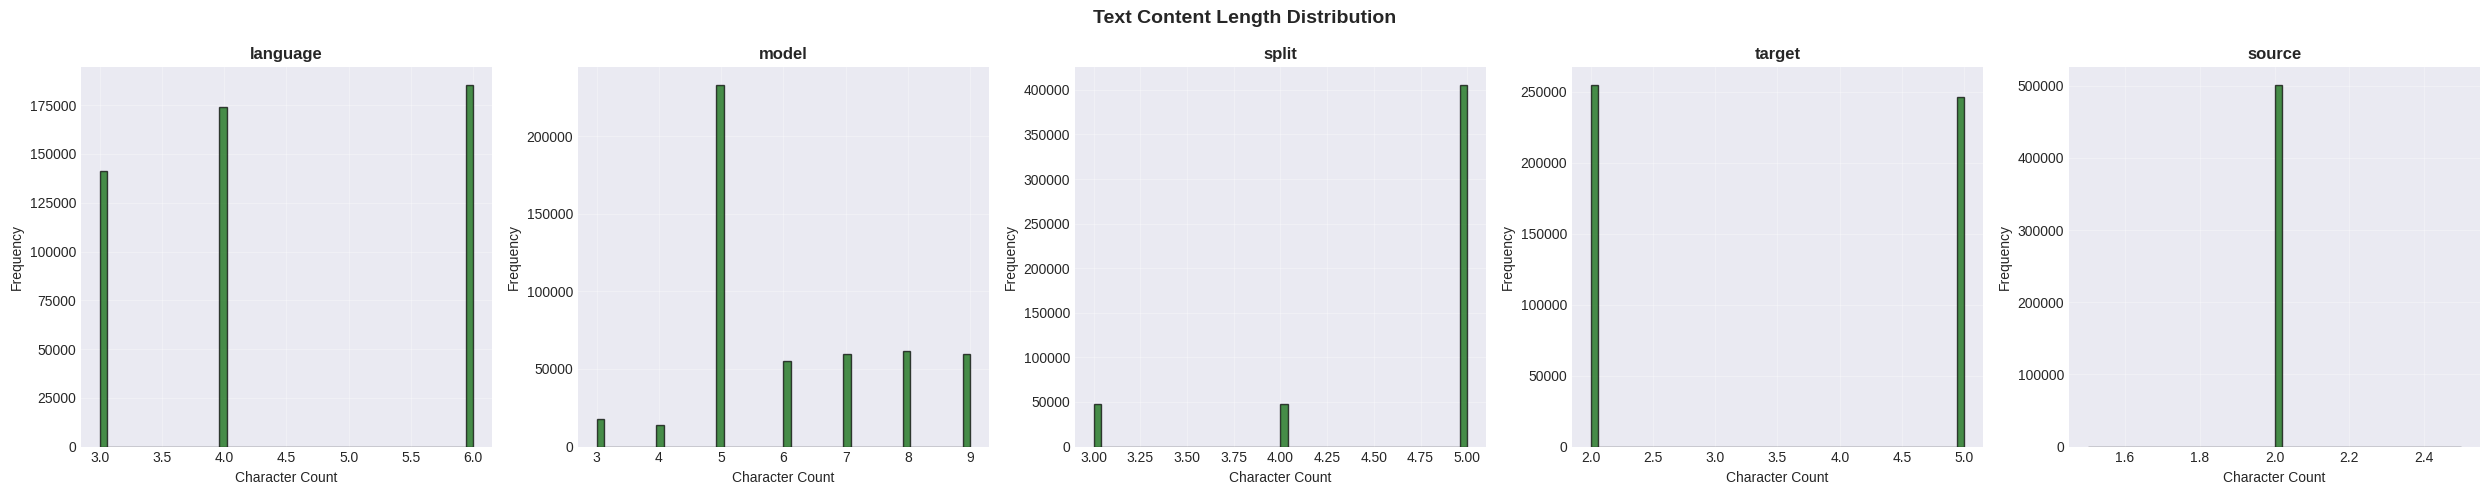

In [6]:
# Understanding text lengths upfront prevents downstream surprises - extreme length variations can break models that aren't prepared for it.
# This tells us if we need truncation strategies or if certain code samples are vastly different in complexity, affecting data stratification decisions.
if text_features:
    fig, axes = plt.subplots(1, len(text_features), figsize=(5*len(text_features), 5))
    if len(text_features) == 1:
        axes = [axes]

    for idx, feature in enumerate(text_features):
        lengths = df_train[feature].astype(str).str.len()
        axes[idx].hist(lengths, bins=50, color='darkgreen', edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'{feature}', fontweight='bold')
        axes[idx].set_xlabel('Character Count')
        axes[idx].set_ylabel('Frequency')
        axes[idx].grid(True, alpha=0.3)

    fig.suptitle('Text Content Length Distribution', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

## Key Insights & Summary

Summary statistics of the analyzed dataset provide a quick reference for the primary metrics.

In [7]:
# Summary statistics for key metrics
summary_stats = []
for metric in numeric_features:
    summary_stats.append({
        'Metric': metric,
        'Mean': f"{df_train[metric].mean():.2f}",
        'Median': f"{df_train[metric].median():.2f}",
        'Std Dev': f"{df_train[metric].std():.2f}",
        'Min': f"{df_train[metric].min():.2f}",
        'Max': f"{df_train[metric].max():.2f}"
    })

summary_df = pd.DataFrame(summary_stats)
summary_df

,Metric,Mean,Median,Std Dev,Min,Max
0,avgFunctionLength,0.84,1.00,0.36,0.00,1.00
1,avgIdentifierLength,4.65,4.29,2.10,0.00,230.28
2,avgLineLength,28.11,26.53,41.46,0.00,24710.50
3,emptyLinesDensity,0.19,0.13,0.19,0.00,1.00
4,functionDefinitionDensity,6.16,0.09,12.91,0.00,1863.00
5,maintainabilityIndex,9.35,0.00,18.04,0.00,100.00
6,maxDecisionTokens,1.49,0.00,2.86,0.00,131.00
7,whiteSpaceRatio,0.30,0.30,0.11,0.00,1.00


## Deep Dive: Categorical Variables Analysis

Understanding the distribution and impact of programming languages, AI models, and data sources is crucial for interpreting code quality patterns across different contexts.

In [8]:
# Categorical Variables Overview
categorical_cols = ['language', 'model', 'source']
categorical_summary = {}

for col in categorical_cols:
    if col in df_train.columns:
        categorical_summary[col] = df_train[col].value_counts()

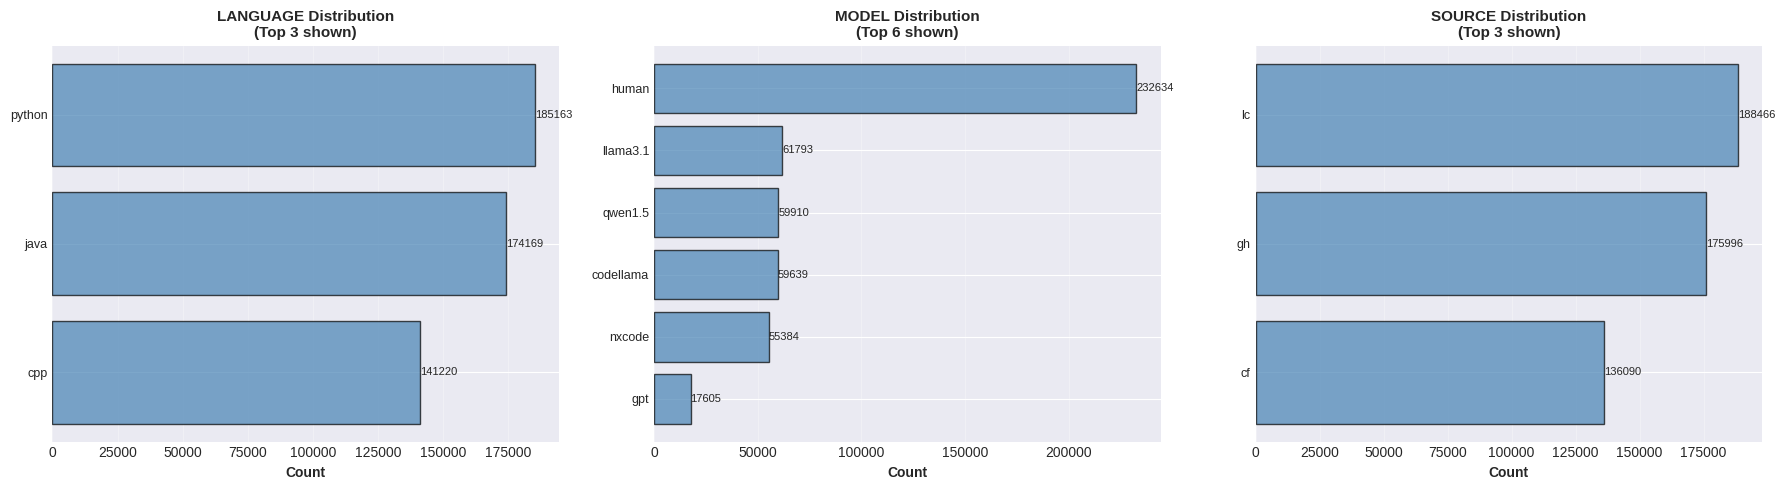

In [9]:
# Horizontal bar charts are the workhorse for category comparisons - they scale well and labels stay readable even with many categories.
# This distribution directly impacts our ability to draw reliable conclusions per language/model; severe imbalance means certain groups might be underrepresented.
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, col in enumerate(categorical_cols):
    if col in df_train.columns:
        value_counts = df_train[col].value_counts().head(15)  # Top 15 for readability

        axes[idx].barh(range(len(value_counts)), value_counts.values, color='steelblue', edgecolor='black', alpha=0.7)
        axes[idx].set_yticks(range(len(value_counts)))
        axes[idx].set_yticklabels(value_counts.index, fontsize=9)
        axes[idx].set_xlabel('Count', fontweight='bold')
        axes[idx].set_title(f'{col.upper()} Distribution\n(Top {min(15, len(value_counts))} shown)', fontweight='bold', fontsize=11)
        axes[idx].grid(True, alpha=0.3, axis='x')
        axes[idx].invert_yaxis()

        # Add count labels
        for i, v in enumerate(value_counts.values):
            axes[idx].text(v + 10, i, str(v), va='center', fontsize=8)

plt.tight_layout()
plt.show()

/tmp/ipython-input-2852947628.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[row, 0].boxplot(grouped_data, labels=top_categories, patch_artist=True)
/tmp/ipython-input-2852947628.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[row, 0].boxplot(grouped_data, labels=top_categories, patch_artist=True)
/tmp/ipython-input-2852947628.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[row, 0].boxplot(grouped_data, labels=top_categories, patch_artist=True)


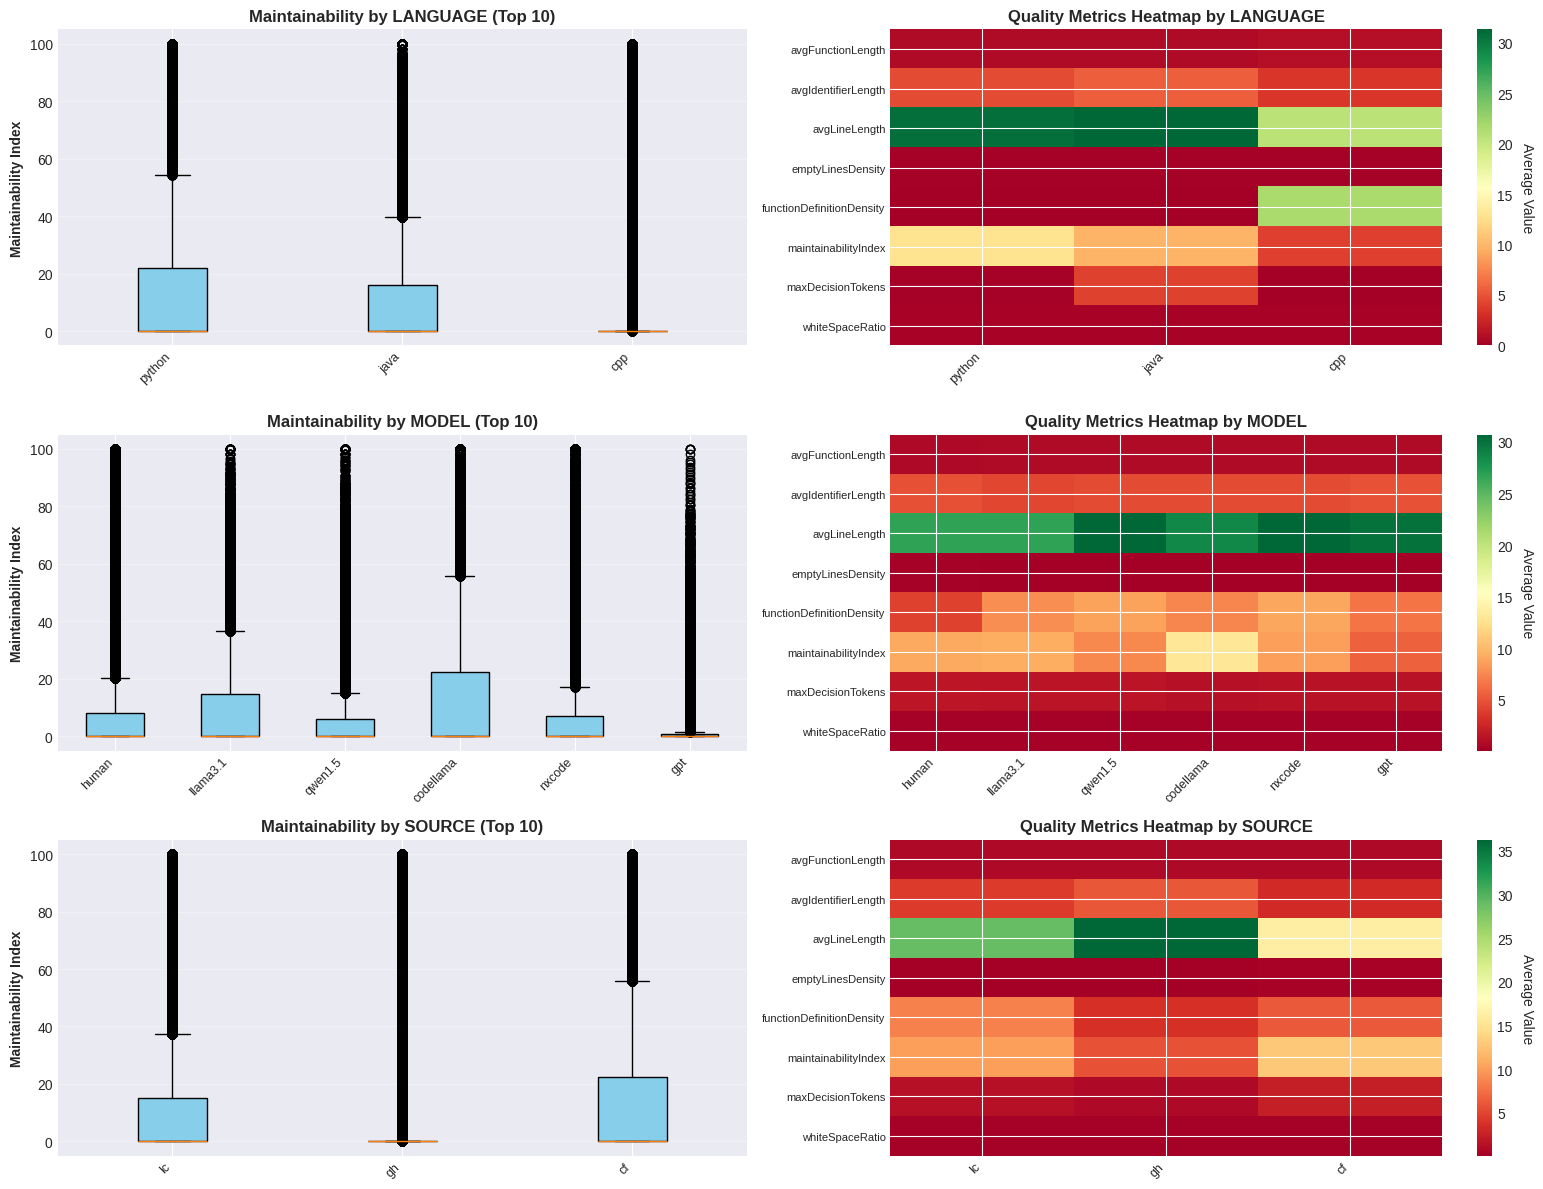

In [10]:
# Boxplots + heatmaps give us the two-level view we need: first, which category has the best/worst quality (boxplot), then why (the metric breakdown via heatmap).
# This drives actionable insights for product teams - if Python outperforms Java, they need to know if it's better function structure, lower complexity, or something else entirely.
fig, axes = plt.subplots(3, 2, figsize=(16, 12))

metric_to_analyze = 'maintainabilityIndex'

for row, col in enumerate(categorical_cols):
    if col in df_train.columns:
        # Top categories
        top_categories = df_train[col].value_counts().head(10).index
        df_filtered = df_train[df_train[col].isin(top_categories)]

        # Boxplot
        grouped_data = [df_filtered[df_filtered[col] == cat][metric_to_analyze].dropna()
                        for cat in top_categories]
        bp = axes[row, 0].boxplot(grouped_data, labels=top_categories, patch_artist=True)

        for patch in bp['boxes']:
            patch.set_facecolor('#87CEEB')

        axes[row, 0].set_xticklabels(top_categories, rotation=45, ha='right', fontsize=9)
        axes[row, 0].set_ylabel('Maintainability Index', fontweight='bold')
        axes[row, 0].set_title(f'Maintainability by {col.upper()} (Top 10)', fontweight='bold')
        axes[row, 0].grid(True, alpha=0.3, axis='y')

        # Average metrics by category
        avg_metrics = df_filtered.groupby(col)[numeric_features].mean().loc[top_categories]

        # Heatmap
        im = axes[row, 1].imshow(avg_metrics.T.values, cmap='RdYlGn', aspect='auto')
        axes[row, 1].set_xticks(range(len(top_categories)))
        axes[row, 1].set_xticklabels(top_categories, rotation=45, ha='right', fontsize=9)
        axes[row, 1].set_yticks(range(len(numeric_features)))
        axes[row, 1].set_yticklabels(numeric_features, fontsize=8)
        axes[row, 1].set_title(f'Quality Metrics Heatmap by {col.upper()}', fontweight='bold')

        # Add colorbar
        cbar = plt.colorbar(im, ax=axes[row, 1])
        cbar.set_label('Average Value', rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

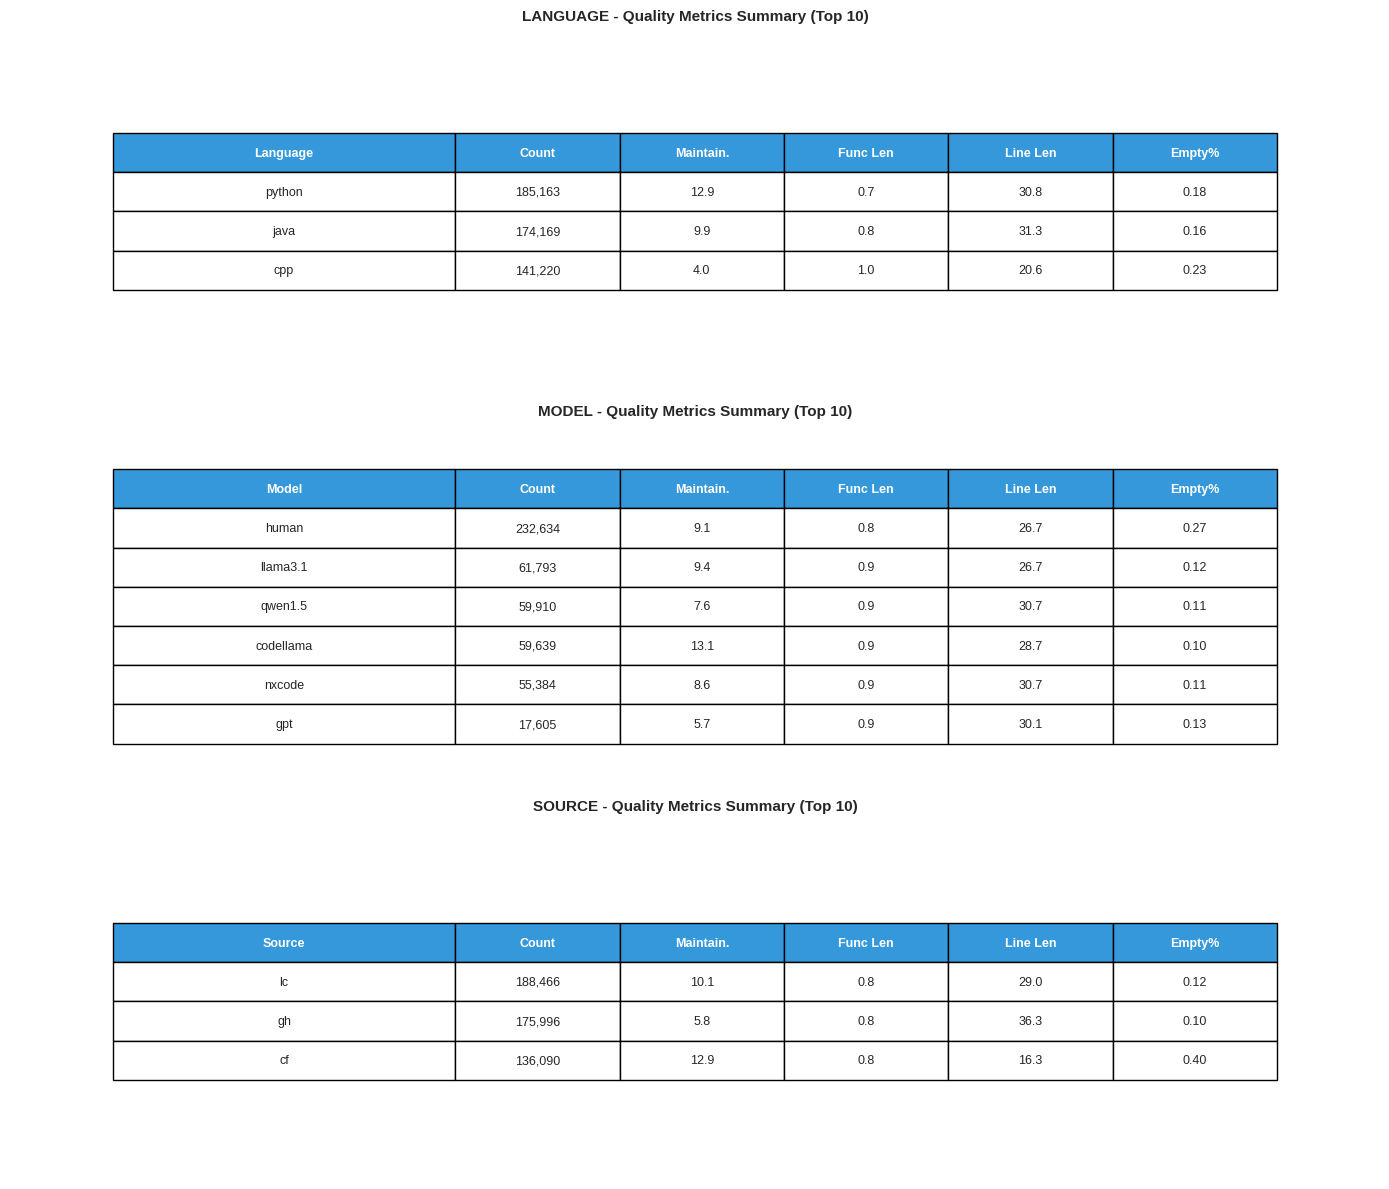

In [11]:
# Tables work here because stakeholders often want exact numbers for their reports - they need the specific maintenance score for Python vs Java.
# Executive dashboards live on these aggregated numbers; having them formatted and sortable by key metrics makes the business case clear and defensible.
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

for idx, col in enumerate(categorical_cols):
    if col in df_train.columns:
        top_cats = df_train[col].value_counts().head(10).index
        summary_data = []

        for cat in top_cats:
            cat_data = df_train[df_train[col] == cat]
            summary_data.append({
                col.capitalize(): cat,
                'Count': f"{len(cat_data):,}",
                'Maintain.': f"{cat_data['maintainabilityIndex'].mean():.1f}",
                'Func Len': f"{cat_data['avgFunctionLength'].mean():.1f}",
                'Line Len': f"{cat_data['avgLineLength'].mean():.1f}",
                'Empty%': f"{cat_data['emptyLinesDensity'].mean():.2f}"
            })

        summary_table = pd.DataFrame(summary_data)

        axes[idx].axis('tight')
        axes[idx].axis('off')
        table = axes[idx].table(cellText=summary_table.values,
                               colLabels=summary_table.columns,
                               cellLoc='center', loc='center',
                               colWidths=[0.25, 0.12, 0.12, 0.12, 0.12, 0.12])
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1, 1.8)

        # Color header
        for i in range(len(summary_table.columns)):
            table[(0, i)].set_facecolor('#3498db')
            table[(0, i)].set_text_props(weight='bold', color='white')

        axes[idx].set_title(f'{col.upper()} - Quality Metrics Summary (Top 10)',
                           fontweight='bold', fontsize=11, pad=10)

plt.tight_layout()
plt.show()

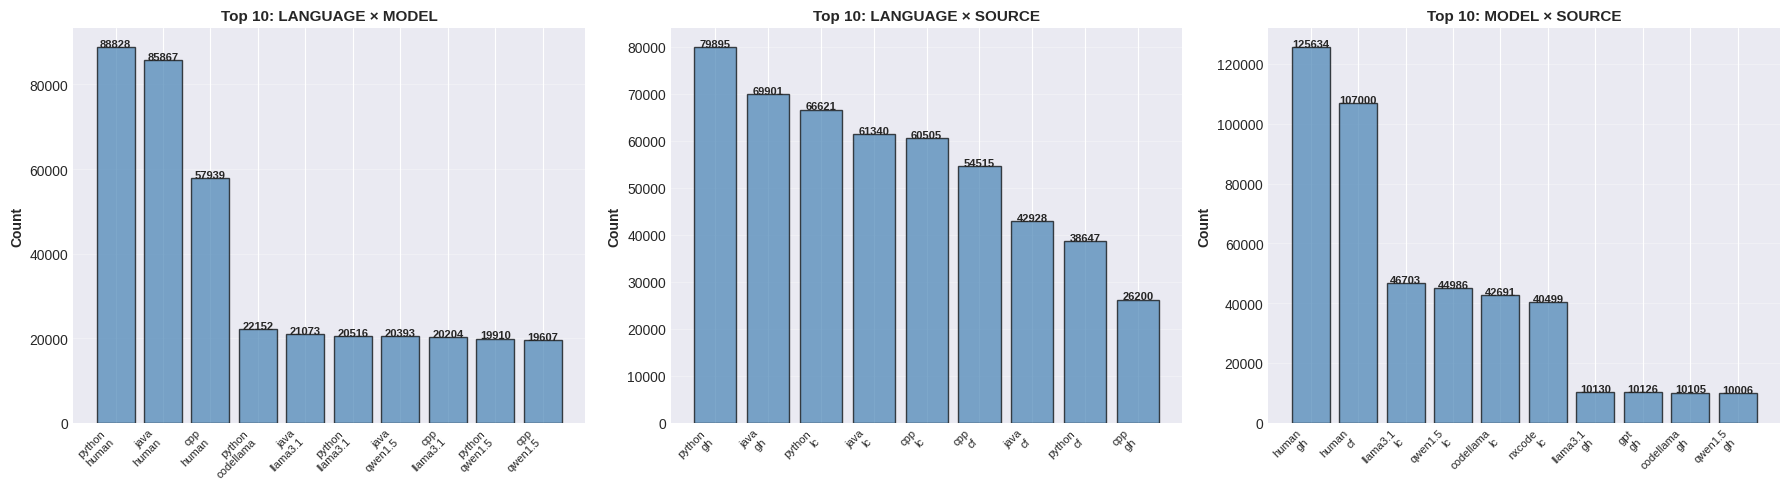

In [12]:
# Stacked categories matter more than individual ones - a language might be fine in isolation but problematic when paired with a specific model.
# This reveals interaction effects that single-variable analysis misses, helping prioritize which combinations to invest in improving first.
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

combinations = [
    ('language', 'model'),
    ('language', 'source'),
    ('model', 'source')
]

for idx, (col1, col2) in enumerate(combinations):
    if col1 in df_train.columns and col2 in df_train.columns:
        combo_data = df_train.groupby([col1, col2]).size().reset_index(name='count').sort_values('count', ascending=False).head(10)

        # Create labels
        labels = [f"{row[0][:12]}\n{row[1][:12]}" for row in combo_data[[col1, col2]].values]
        values = combo_data['count'].values

        axes[idx].bar(range(len(values)), values, color='steelblue', edgecolor='black', alpha=0.7)
        axes[idx].set_xticks(range(len(values)))
        axes[idx].set_xticklabels(labels, fontsize=8, rotation=45, ha='right')
        axes[idx].set_ylabel('Count', fontweight='bold')
        axes[idx].set_title(f'Top 10: {col1.upper()} × {col2.upper()}', fontweight='bold', fontsize=11)
        axes[idx].grid(True, alpha=0.3, axis='y')

        # Add value labels on bars
        for i, v in enumerate(values):
            axes[idx].text(i, v + 20, str(v), ha='center', fontweight='bold', fontsize=8)

plt.tight_layout()
plt.show()

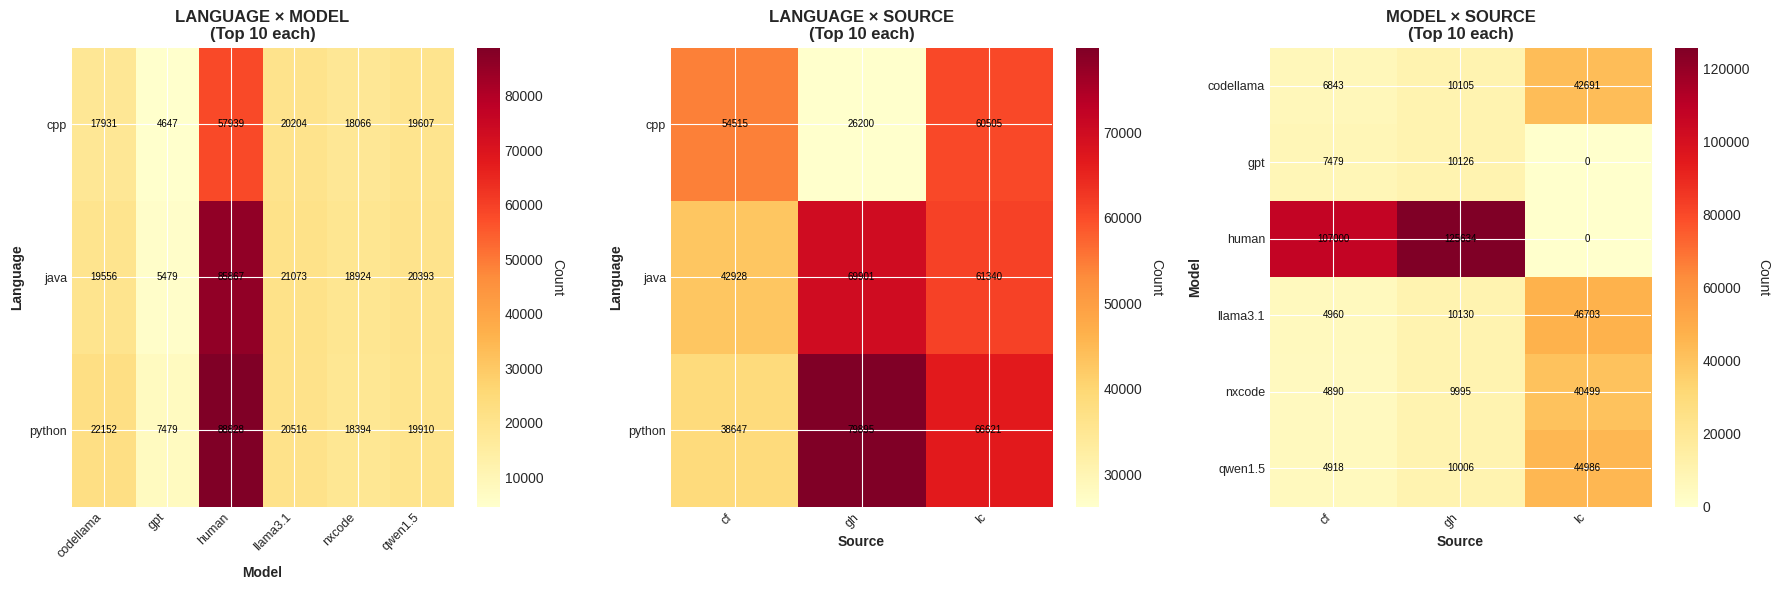

In [13]:
# Heatmaps are perfect for showing the full cross-tabulation grid at once - empty cells (white) jump out immediately where we have data gaps.
# Identifying sparsity in certain combinations tells us where we might have reliability issues in our conclusions or where we need to collect more data.
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

combinations = [
    ('language', 'model'),
    ('language', 'source'),
    ('model', 'source')
]

for idx, (col1, col2) in enumerate(combinations):
    if col1 in df_train.columns and col2 in df_train.columns:
        # Get top 10 for each dimension
        top_col1 = df_train[col1].value_counts().head(10).index
        top_col2 = df_train[col2].value_counts().head(10).index

        df_filtered = df_train[df_train[col1].isin(top_col1) & df_train[col2].isin(top_col2)]
        crosstab = pd.crosstab(df_filtered[col1], df_filtered[col2])

        # Heatmap
        im = axes[idx].imshow(crosstab.values, cmap='YlOrRd', aspect='auto')
        axes[idx].set_xticks(range(len(crosstab.columns)))
        axes[idx].set_yticks(range(len(crosstab.index)))
        axes[idx].set_xticklabels(crosstab.columns, rotation=45, ha='right', fontsize=9)
        axes[idx].set_yticklabels(crosstab.index, fontsize=9)
        axes[idx].set_xlabel(col2.capitalize(), fontweight='bold')
        axes[idx].set_ylabel(col1.capitalize(), fontweight='bold')
        axes[idx].set_title(f'{col1.upper()} × {col2.upper()}\n(Top 10 each)', fontweight='bold')

        # Add colorbar
        cbar = plt.colorbar(im, ax=axes[idx])
        cbar.set_label('Count', rotation=270, labelpad=15)

        # Add text annotations
        for i in range(len(crosstab.index)):
            for j in range(len(crosstab.columns)):
                text = axes[idx].text(j, i, int(crosstab.values[i, j]),
                                     ha="center", va="center", color="black", fontsize=7)

plt.tight_layout()
plt.show()